<h1 style='color:purple' align='center'>Data Science Regression Project: Predicting Home Prices in Faridabad</h1>

Dataset is downloaded from here: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

<h2 style='color:blue'>Data Load: Load banglore home prices into a dataframe</h2>

In [2]:
df1 = pd.read_csv("faridabad_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Built-up Area,Ready To Move,Greater Faridabad,1 RK,NaN,351,1.0,1.0,16.00
1,Super built-up Area,Ready To Move,Greater Faridabad,1 RK,Krntsee,527,1.0,0.0,35.00
2,Super built-up Area,Ready To Move,Greater Faridabad,1 RK,NaN,670,1.0,1.0,50.00
3,Super built-up Area,19-Dec,Greater Faridabad,1 RK,Rosha I,296,1.0,0.0,22.89
4,Super built-up Area,Ready To Move,Greater Faridabad,2 BHK,NaN,1100,2.0,1.0,70.00


In [3]:
df1.shape

(9999, 9)

In [4]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

<Axes: >

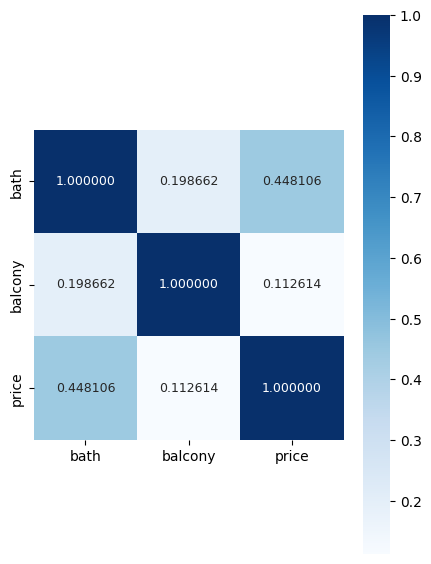

In [5]:
corr_df=df1.corr(numeric_only=True)
plt.figure(figsize=(5,7))
sns.heatmap(corr_df,cbar=True,square=True,fmt='1f',annot=True,annot_kws={'size':9},cmap='Blues')

In [6]:
df1['area_type'].unique()

array(['Built-up  Area', 'Super built-up  Area', 'Plot  Area',
       'Carpet  Area'], dtype=object)

In [7]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    6560
Built-up  Area          1851
Plot  Area              1513
Carpet  Area              75
Name: count, dtype: int64

**Drop features that are not required to build our model**

In [8]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(9999, 5)

<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

In [9]:
df2.isnull().sum()

location       0
size          12
total_sqft     0
bath          55
price          0
dtype: int64

In [10]:
df2.shape

(9999, 5)

In [11]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [12]:
df3.shape

(9944, 5)

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [13]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\Hp\AppData\Local\Temp\ipykernel_9376\2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 1,  2,  3,  4, 11, 14, 19, 13, 18,  5,  8,  7, 10,  6, 27,  9, 16,
       43, 12])

**Explore total_sqft feature**

In [14]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [15]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
32,Greater Faridabad,1 RK,385 - 440,1.0,19.800,1
96,Greater Faridabad,1 BHK,78.03Sq. Meter,1.0,63.000,1
119,Greater Faridabad,2 Bedroom,1.25Acres,2.0,200.000,2
234,Greater Faridabad,5 Bedroom,24Guntha,6.0,550.000,5
470,Greater Faridabad,2 BHK,120Sq. Yards,2.0,51.000,2
490,Greater Faridabad,2 BHK,1042 - 1105,2.0,54.005,2
514,Greater Faridabad,3 BHK,1408 - 1455,3.0,72.020,3
1017,Greater Faridabad,1 BHK,660 - 780,1.0,32.390,1
1050,Greater Faridabad,9 Bedroom,4125Perch,9.0,265.000,9
1065,Greater Faridabad,1 Bedroom,38Guntha,1.0,170.000,1


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [16]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [17]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Greater Faridabad,1 RK,351.0,1.0,16.0,1
1,Greater Faridabad,1 RK,527.0,1.0,35.0,1


**For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850**

In [18]:
df4.loc[30]

location      Greater Faridabad
size                      1 BHK
total_sqft                700.0
bath                        1.0
price                      25.5
bhk                           1
Name: 30, dtype: object

<h2 style="color:blue">Feature Engineering</h2>

**Add new feature called price per square feet**

In [19]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Greater Faridabad,1 RK,351.0,1.0,16.00,1,4558.404558
1,Greater Faridabad,1 RK,527.0,1.0,35.00,1,6641.366224
2,Greater Faridabad,1 RK,670.0,1.0,50.00,1,7462.686567
3,Greater Faridabad,1 RK,296.0,1.0,22.89,1,7733.108108
4,Greater Faridabad,2 BHK,1100.0,2.0,70.00,2,6363.636364


In [20]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count      9908.000000
mean       6824.260525
std        7807.555384
min         267.829813
25%        4250.415100
50%        5380.366118
75%        7405.043341
max      625000.000000
Name: price_per_sqft, dtype: float64

In [21]:
df5.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [22]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

location
New Industrial Town    1990
Greater Faridabad      1987
Village Area           1981
Old Faridabad          1977
Ballabgarh             1973
Name: count, dtype: int64

In [23]:
location_stats.values.sum()

np.int64(9908)

In [24]:
len(location_stats[location_stats>10])

5

In [25]:
len(location_stats)

5

In [26]:
len(location_stats[location_stats<=10])

0

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [27]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Series([], Name: count, dtype: int64)

In [28]:
len(df5.location.unique())

5

In [29]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

5

In [30]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Greater Faridabad,1 RK,351.0,1.0,16.00,1,4558.404558
1,Greater Faridabad,1 RK,527.0,1.0,35.00,1,6641.366224
2,Greater Faridabad,1 RK,670.0,1.0,50.00,1,7462.686567
3,Greater Faridabad,1 RK,296.0,1.0,22.89,1,7733.108108
4,Greater Faridabad,2 BHK,1100.0,2.0,70.00,2,6363.636364
5,Greater Faridabad,3 BHK,1672.0,3.0,150.00,3,8971.291866
6,Greater Faridabad,3 BHK,1750.0,3.0,149.00,3,8514.285714
7,Greater Faridabad,3 BHK,1670.0,3.0,160.00,3,9580.838323
8,Greater Faridabad,3 BHK,1750.0,3.0,150.00,3,8571.428571
9,Greater Faridabad,2 BHK,1296.0,2.0,70.00,2,5401.234568


<h2 style="color:blue">Outlier Removal Using Business Logic</h2>

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [31]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
3,Greater Faridabad,1 RK,296.0,1.0,22.89,1,7733.108108
26,Greater Faridabad,3 Bedroom,600.0,2.0,110.00,3,18333.333333
40,Greater Faridabad,11 Bedroom,1200.0,6.0,150.00,11,12500.000000
43,Greater Faridabad,11 Bedroom,1200.0,11.0,170.00,11,14166.666667
46,Greater Faridabad,14 BHK,1250.0,15.0,125.00,14,10000.000000


**Check above data points. We have 11 bhk apartment with 1200 sqft. Another one is 14 bhk and total sqft is 125. These are clear data errors that can be removed safely**

In [32]:
df5.shape

(9908, 7)

In [33]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(9325, 7)

<h2 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h2>

In [34]:
df6.price_per_sqft.describe()

count      9325.000000
mean       6346.839596
std        4311.328203
min         267.829813
25%        4200.000000
50%        5248.868778
75%        6956.521739
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is  6346 rs/sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [35]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(8376, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

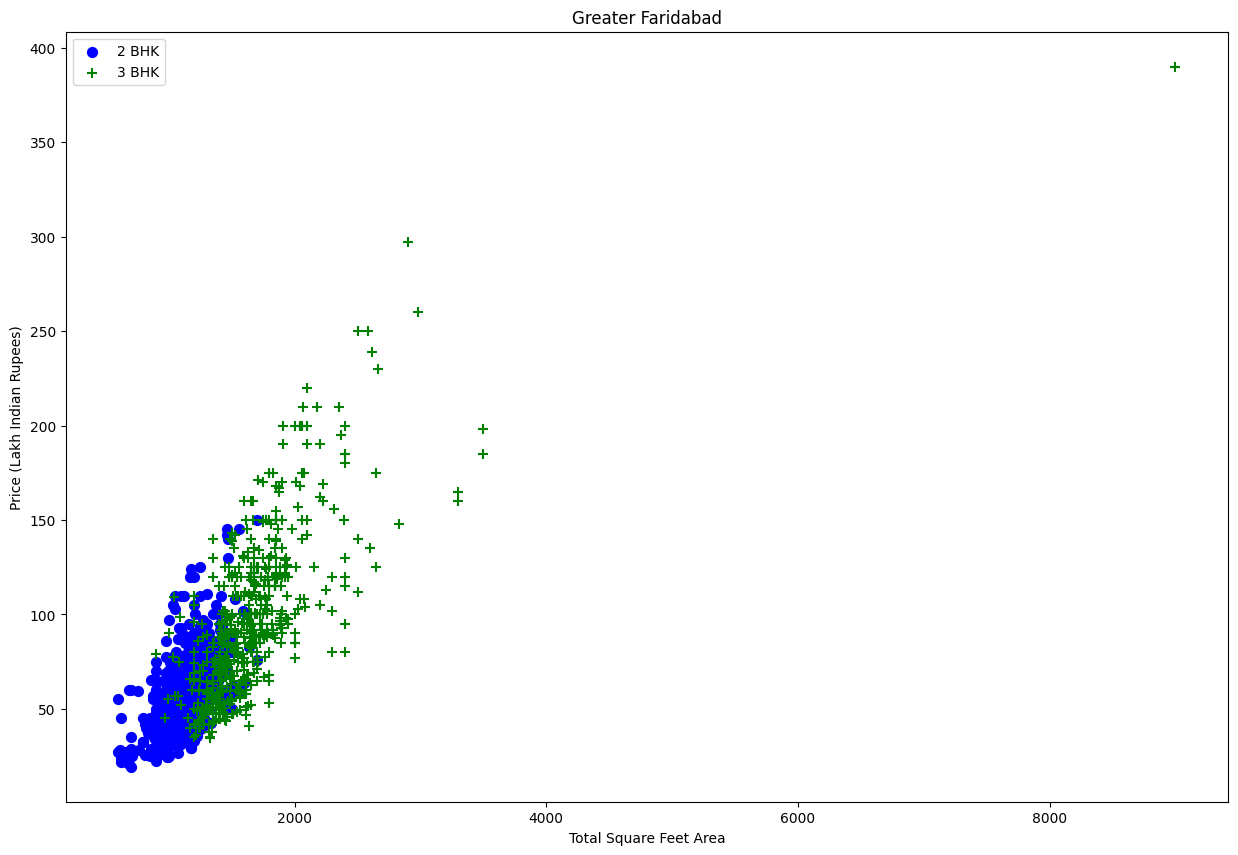

In [36]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Greater Faridabad")

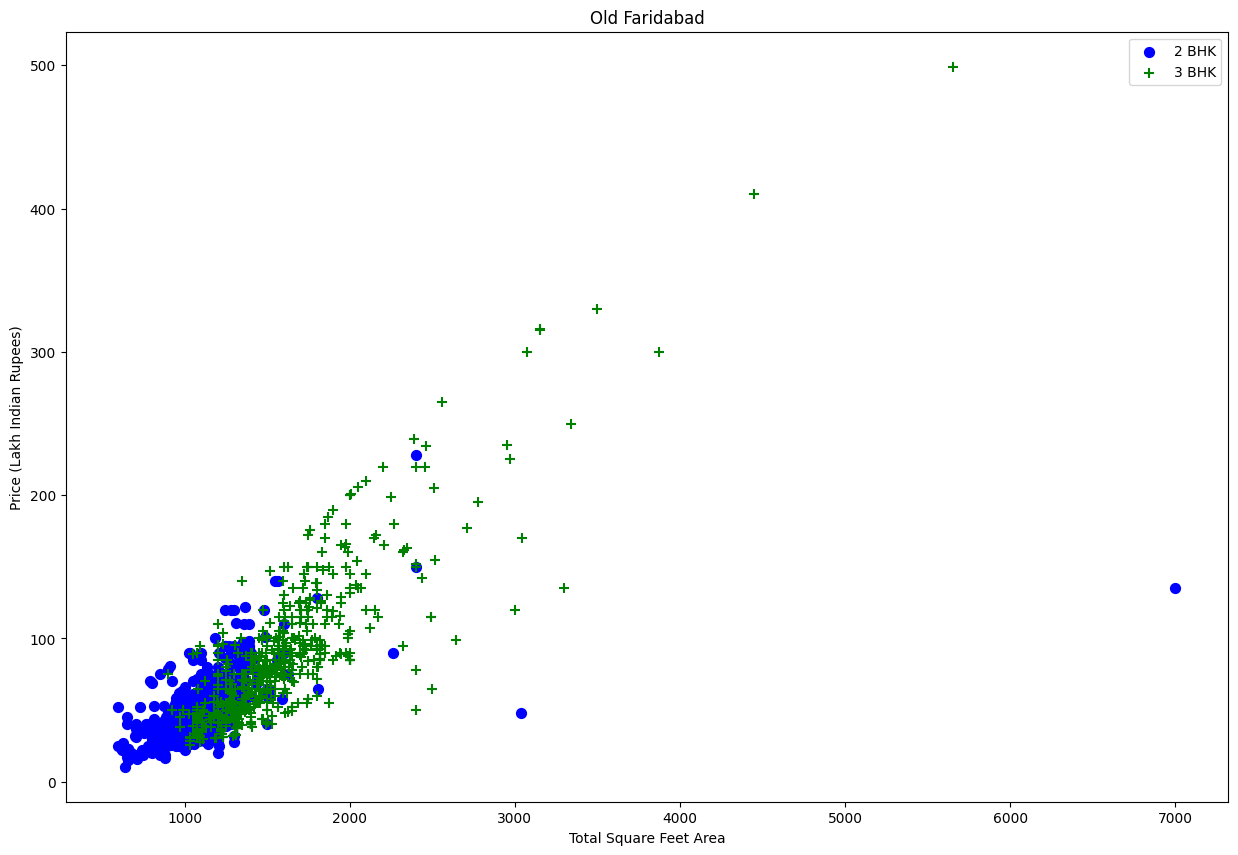

In [37]:
plot_scatter_chart(df7,"Old Faridabad")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [38]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(4323, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

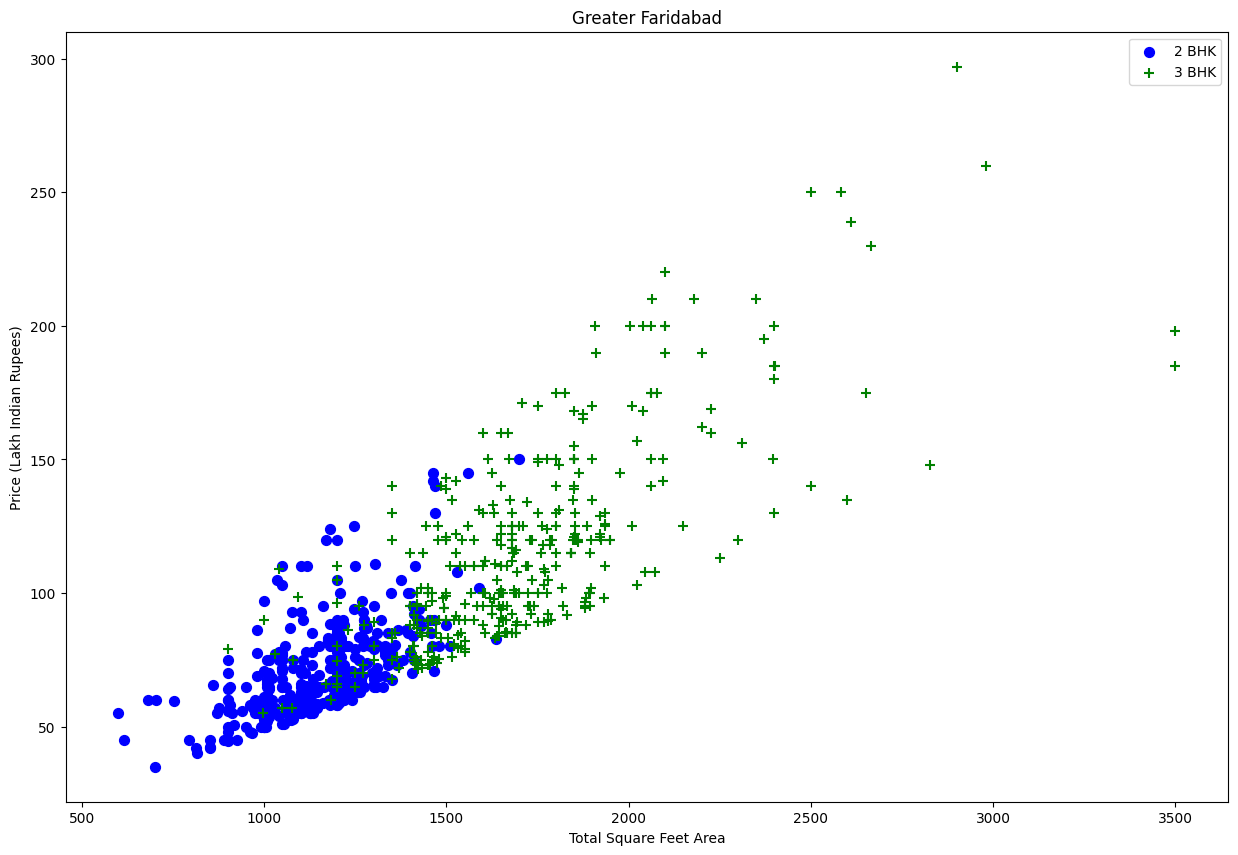

In [39]:
plot_scatter_chart(df8,"Greater Faridabad")

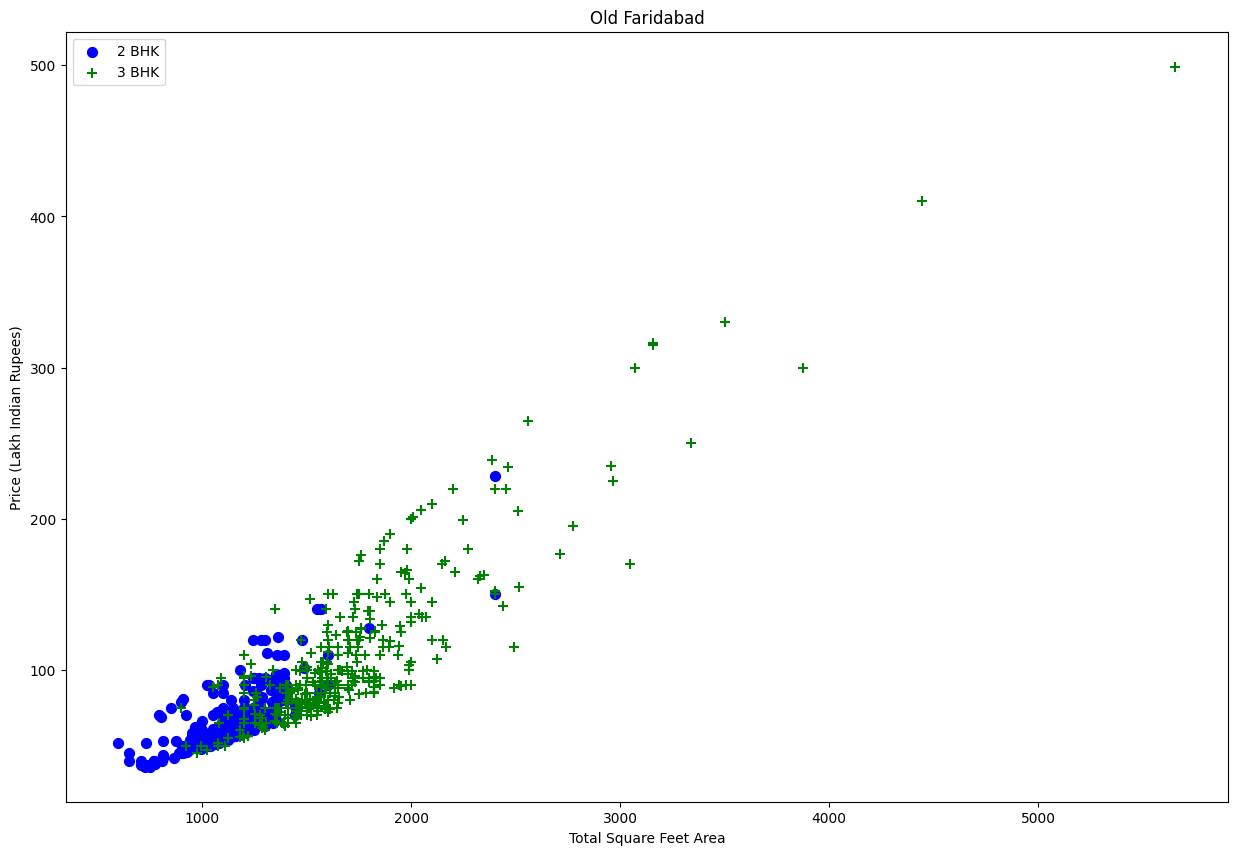

In [40]:
plot_scatter_chart(df8,"Old Faridabad")

Text(0, 0.5, 'Count')

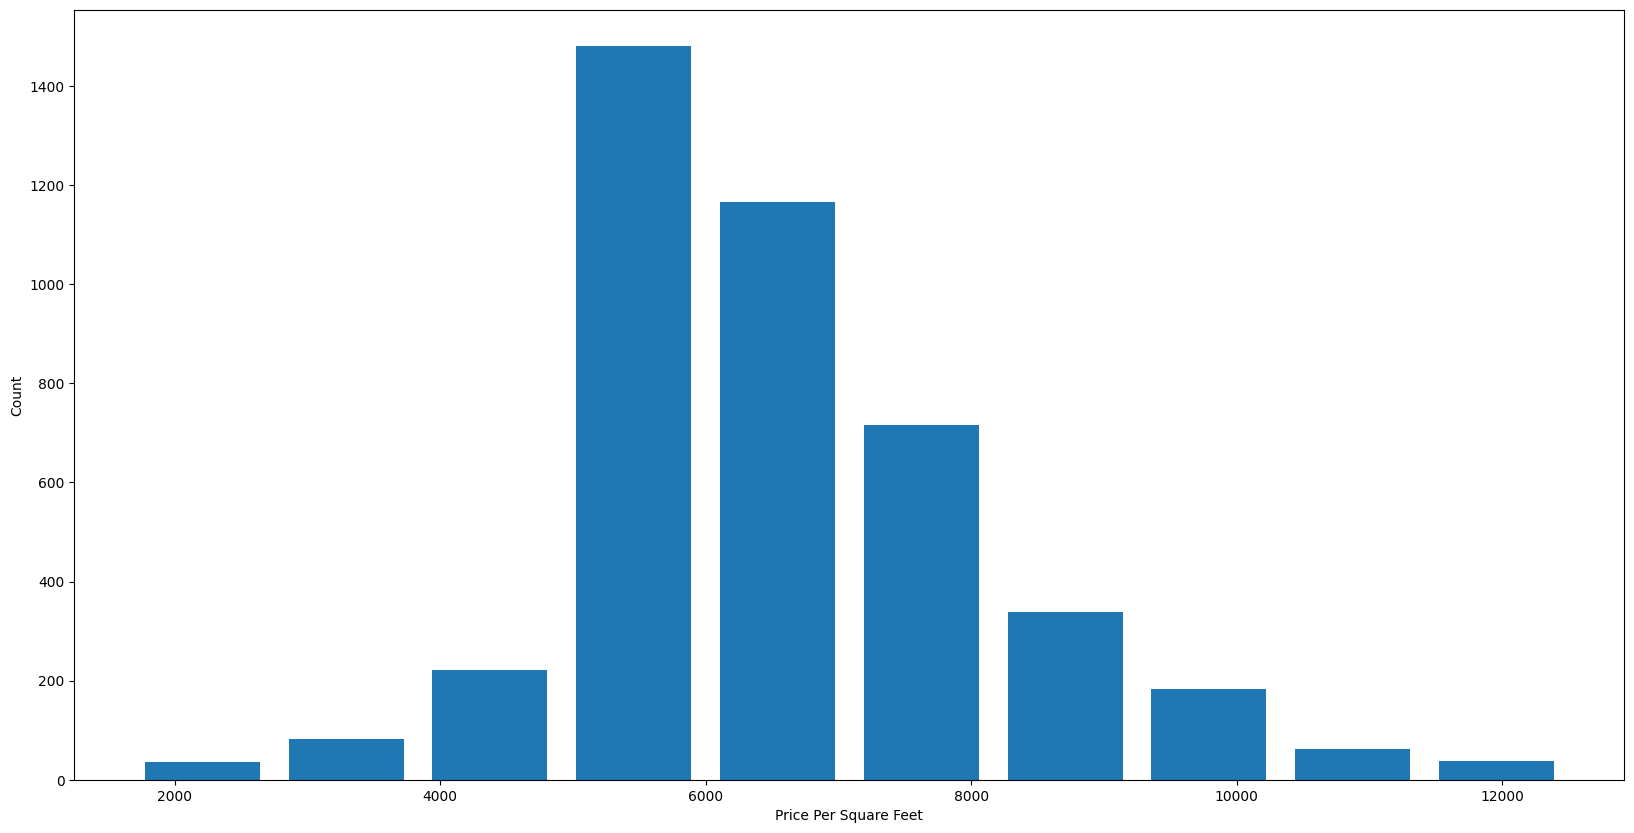

In [41]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [42]:
df8.bath.unique()

array([ 2.,  1.,  3.,  4.,  5., 12.,  9.,  6., 16.,  7., 13.,  8., 10.])

Text(0, 0.5, 'Count')

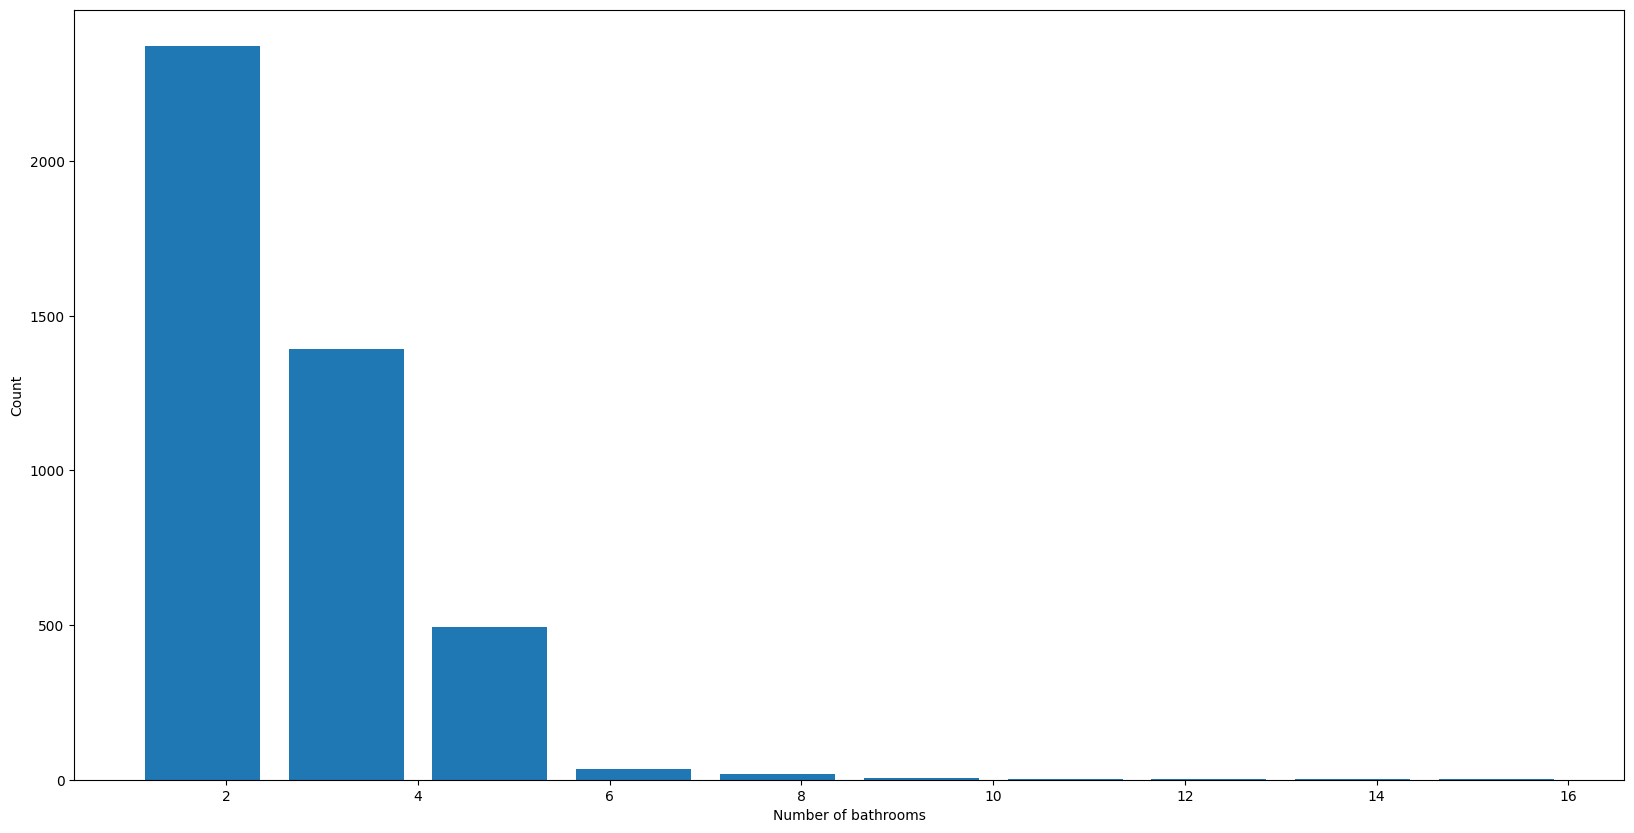

In [43]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [44]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
167,Ballabgarh,10 BHK,12000.0,12.0,525.0,10,4375.000000
1254,Ballabgarh,16 BHK,10000.0,16.0,550.0,16,5500.000000
1682,Greater Faridabad,11 BHK,6000.0,12.0,150.0,11,2500.000000
1683,Greater Faridabad,13 BHK,5425.0,13.0,275.0,13,5069.124424
4042,New Industrial Town,10 BHK,4000.0,12.0,160.0,10,4000.000000


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [45]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
3941,New Industrial Town,4 Bedroom,7000.0,8.0,450.0,4,6428.571429


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [46]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(4282, 7)

In [47]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Ballabgarh,2 BHK,1000.0,2.0,70.0,2,7000.000000
1,Ballabgarh,1 BHK,615.0,1.0,46.0,1,7479.674797


In [48]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,Ballabgarh,1000.0,2.0,70.00,2
1,Ballabgarh,615.0,1.0,46.00,1
2,Ballabgarh,1704.0,3.0,94.36,3


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [49]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,Ballabgarh,Greater Faridabad,New Industrial Town,Old Faridabad,Village Area
0,True,False,False,False,False
1,True,False,False,False,False
2,True,False,False,False,False


In [50]:
df11 = pd.concat([df10,dummies],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,Ballabgarh,Greater Faridabad,New Industrial Town,Old Faridabad,Village Area
0,Ballabgarh,1000.0,2.0,70.00,2,True,False,False,False,False
1,Ballabgarh,615.0,1.0,46.00,1,True,False,False,False,False
2,Ballabgarh,1704.0,3.0,94.36,3,True,False,False,False,False
3,Ballabgarh,1470.0,2.0,102.00,3,True,False,False,False,False
4,Ballabgarh,1244.0,2.0,88.00,2,True,False,False,False,False


In [51]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,Ballabgarh,Greater Faridabad,New Industrial Town,Old Faridabad,Village Area
0,1000.0,2.0,70.0,2,True,False,False,False,False
1,615.0,1.0,46.0,1,True,False,False,False,False


In [52]:
df12 = df12.replace({True: 1, False: 0})

C:\Users\Hp\AppData\Local\Temp\ipykernel_9376\1516407274.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df12 = df12.replace({True: 1, False: 0})


<h2 style='color:blue'>Build a Model Now...</h2>

In [53]:
df12.shape

(4282, 9)

In [54]:
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,Ballabgarh,Greater Faridabad,New Industrial Town,Old Faridabad,Village Area
0,1000.0,2.0,2,1,0,0,0,0
1,615.0,1.0,1,1,0,0,0,0
2,1704.0,3.0,3,1,0,0,0,0


In [55]:
X.shape

(4282, 8)

In [56]:
y = df12.price
y.head(3)

0    70.00
1    46.00
2    94.36
Name: price, dtype: float64

In [57]:
len(y)

4282

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [59]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8422312577156792

In [60]:
y_pred=lr_clf.predict(X_train)

(0.0, 1000.0)

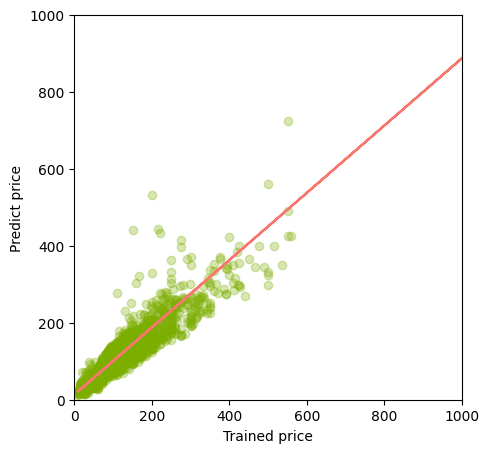

In [61]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_pred, c="#7CAE00" ,alpha=0.3)

z = np.polyfit(y_train, y_pred, 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766D')
plt.ylabel('Predict price')
plt.xlabel('Trained price')
plt.xlim(0, 1000)
plt.ylim(0, 1000)

In [62]:
from sklearn.metrics import r2_score
model_r2=r2_score(y_train,y_pred)
print("R2 score of data: ",model_r2)

R2 score of data:  0.8735797117319214


In [63]:
X_train

,total_sqft,bath,bhk,Ballabgarh,Greater Faridabad,New Industrial Town,Old Faridabad,Village Area
221,1890.0,4.0,3,1,0,0,0,0
104,1230.0,2.0,2,1,0,0,0,0
1832,1707.0,3.0,3,0,1,0,0,0
5,1407.0,2.0,2,1,0,0,0,0
1539,1047.0,2.0,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...
3841,1512.0,2.0,3,0,0,1,0,0
2245,2225.0,4.0,3,0,1,0,0,0
6899,1745.0,3.0,3,0,0,0,0,1
2551,1200.0,1.0,2,0,1,0,0,0


In [64]:
y_train

221     127.00
104      70.00
1832    171.00
5        98.49
1539     84.00
         ...  
3841    110.00
2245    169.00
6899    125.00
2551     65.00
2462    250.00
Name: price, Length: 3425, dtype: float64

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [65]:
import pickle
with open('model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [66]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))